##Yuri Santana Lopes - 222009750

##Primeiro Passo: Preparar o Ambiente!!
Executar todas as células abaixo!

#Importação das bibliotecas

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

#Carregar o arquivo diretamente do Drive

In [3]:
file_id = "1Hxh4JJ-6dUQjrqYhRittczgptoezMfl5"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
adult = pd.read_csv(download_url)

#Ler o arquivo e salvá-lo em uma variável

In [12]:
adult.head()  #Mostrar também as colunas principais do arquivo

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


##Tratamento de dados no Dataset
Verificar se existem valores Nulos ou Outliers dentro do dataset que estamos analisando

In [5]:
print("Os valores nulos são: ",adult.isnull().sum())

Os valores nulos são:  age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


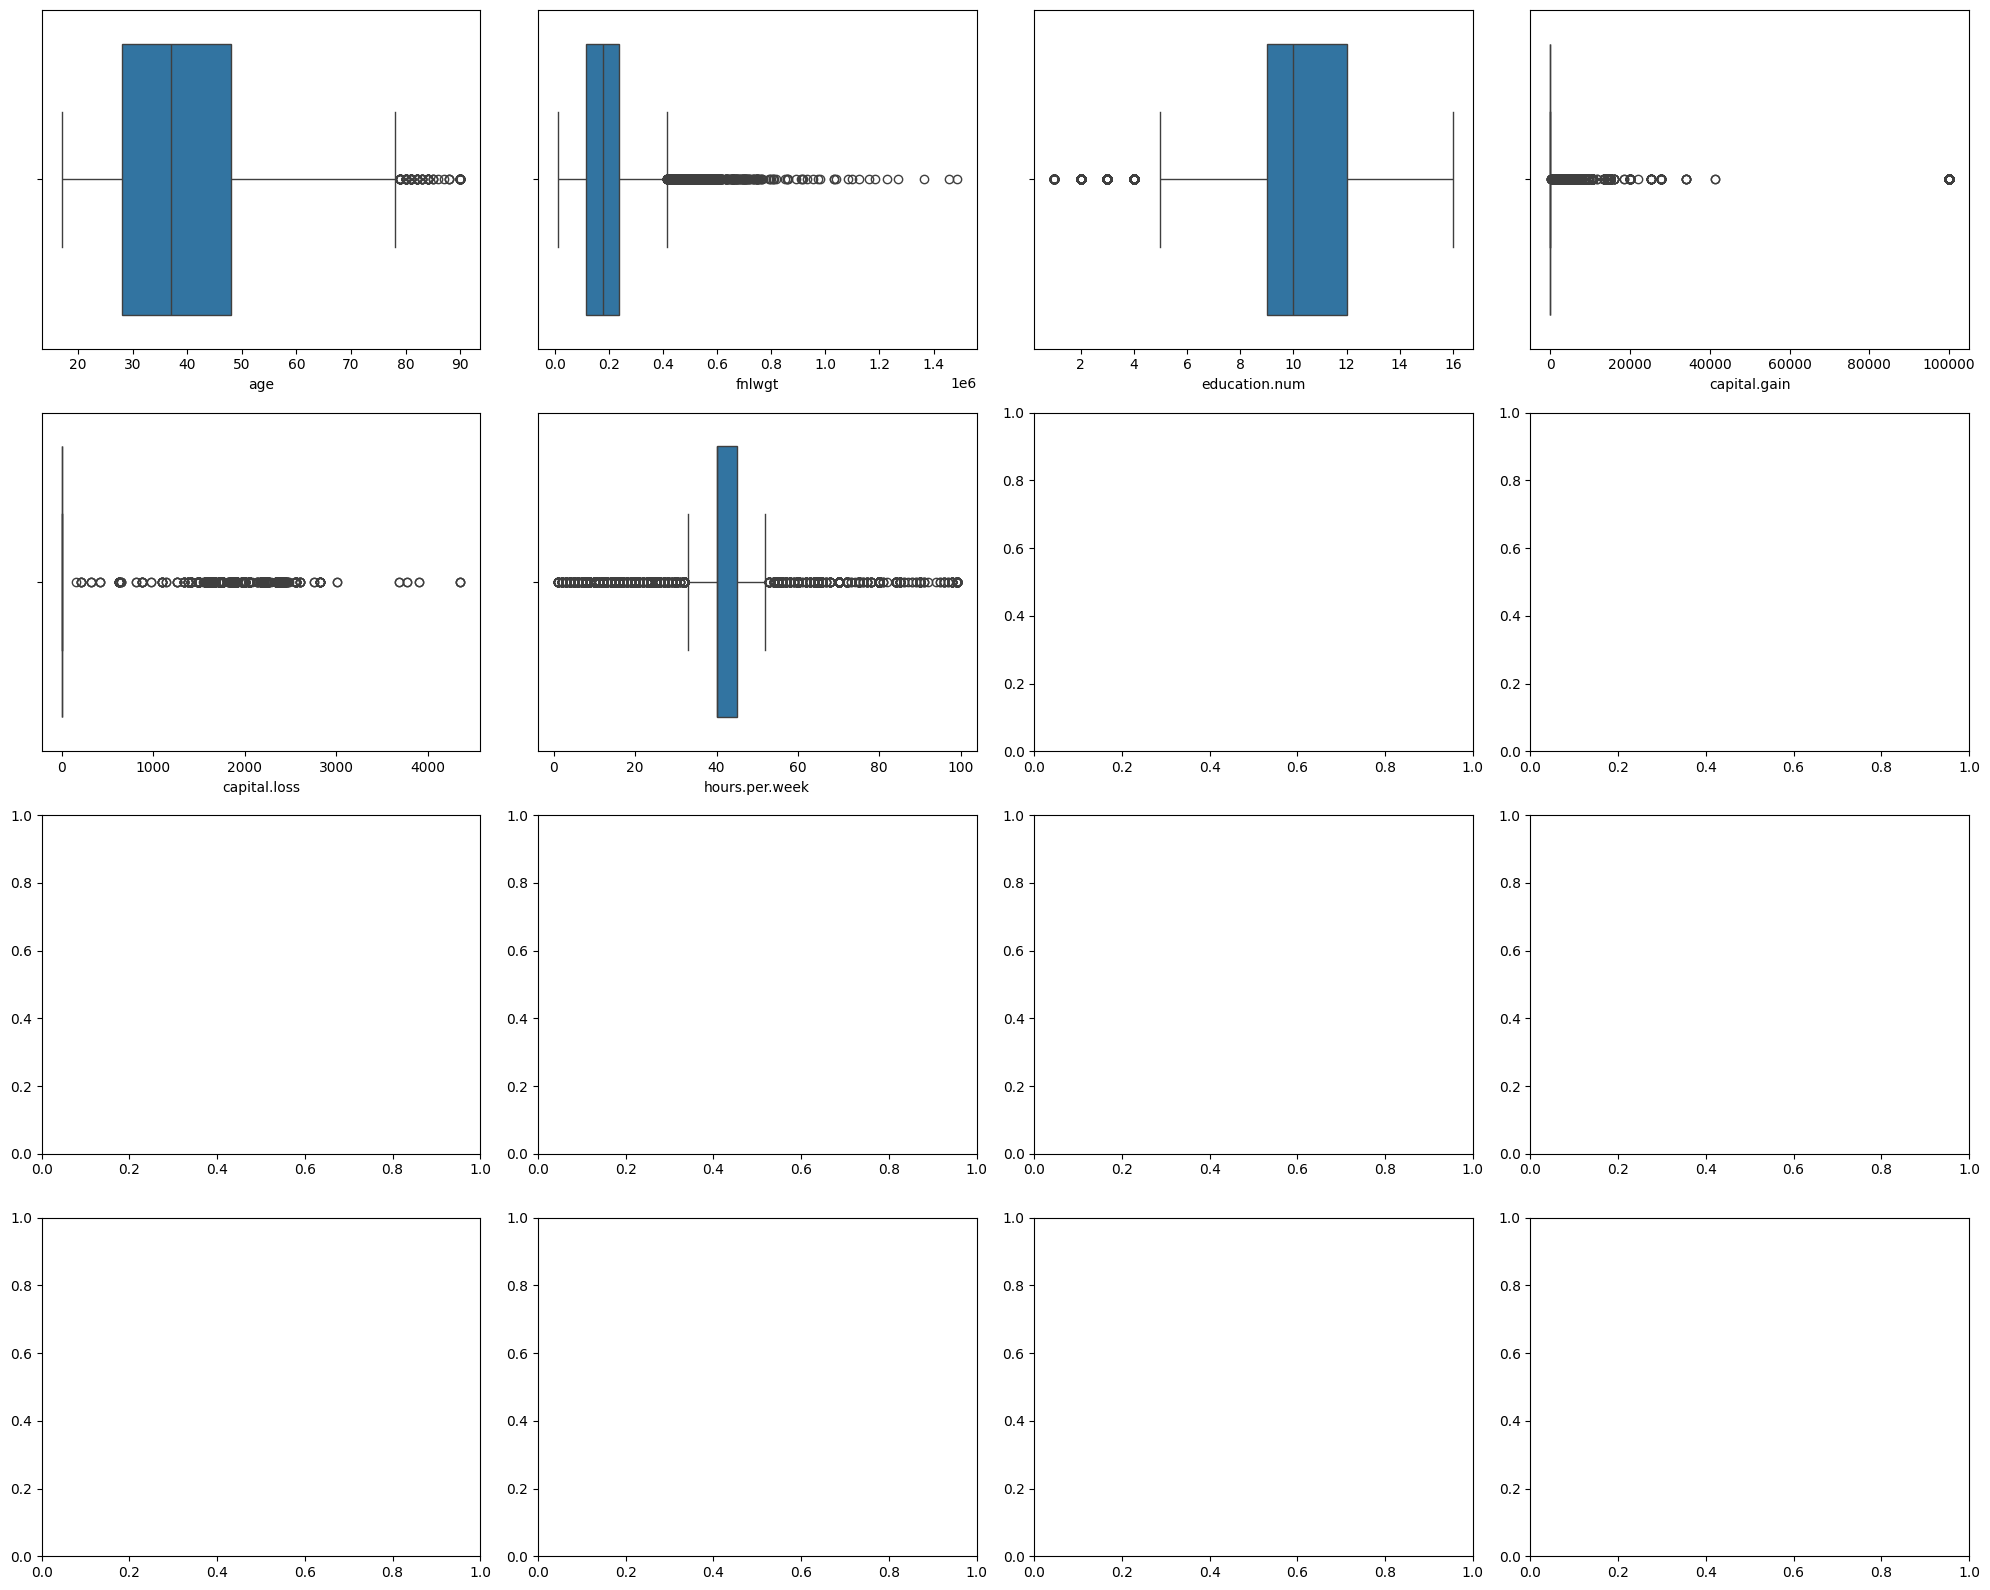

In [6]:
def mostrar_outliers_graficamente(adult):
  num_cols = len(adult.columns) - 1
  cols = 4
  rows = (num_cols + cols - 1) // cols
  numeric_cols = adult.select_dtypes(include=['int64','float64']).columns

  fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
  axes = axes.flatten()

  for idx,col in enumerate(numeric_cols):#Permitir mostrar os graficos ordenamente
      sns.boxplot(x=adult[col],ax = axes[idx])

  plt.tight_layout()
  plt.show()

mostrar_outliers_graficamente(adult)

**Análise de dados no Dataset**
Podemos observar de que ele não apresenta valores vazios, entretanto há uma grande presença de Outliers em nosso dataset.
Entretanto, para que o treinamento seja efetuado da maneira devida é necessário que os outliers sejam tratados de alguma maneira.

**Tratamento de Outliers**
Eu optei por usar a estratégia de simplesmente remover os outliers de nosso dataset.

Tamanho original: 32561
Tamanho sem outliers: 23553


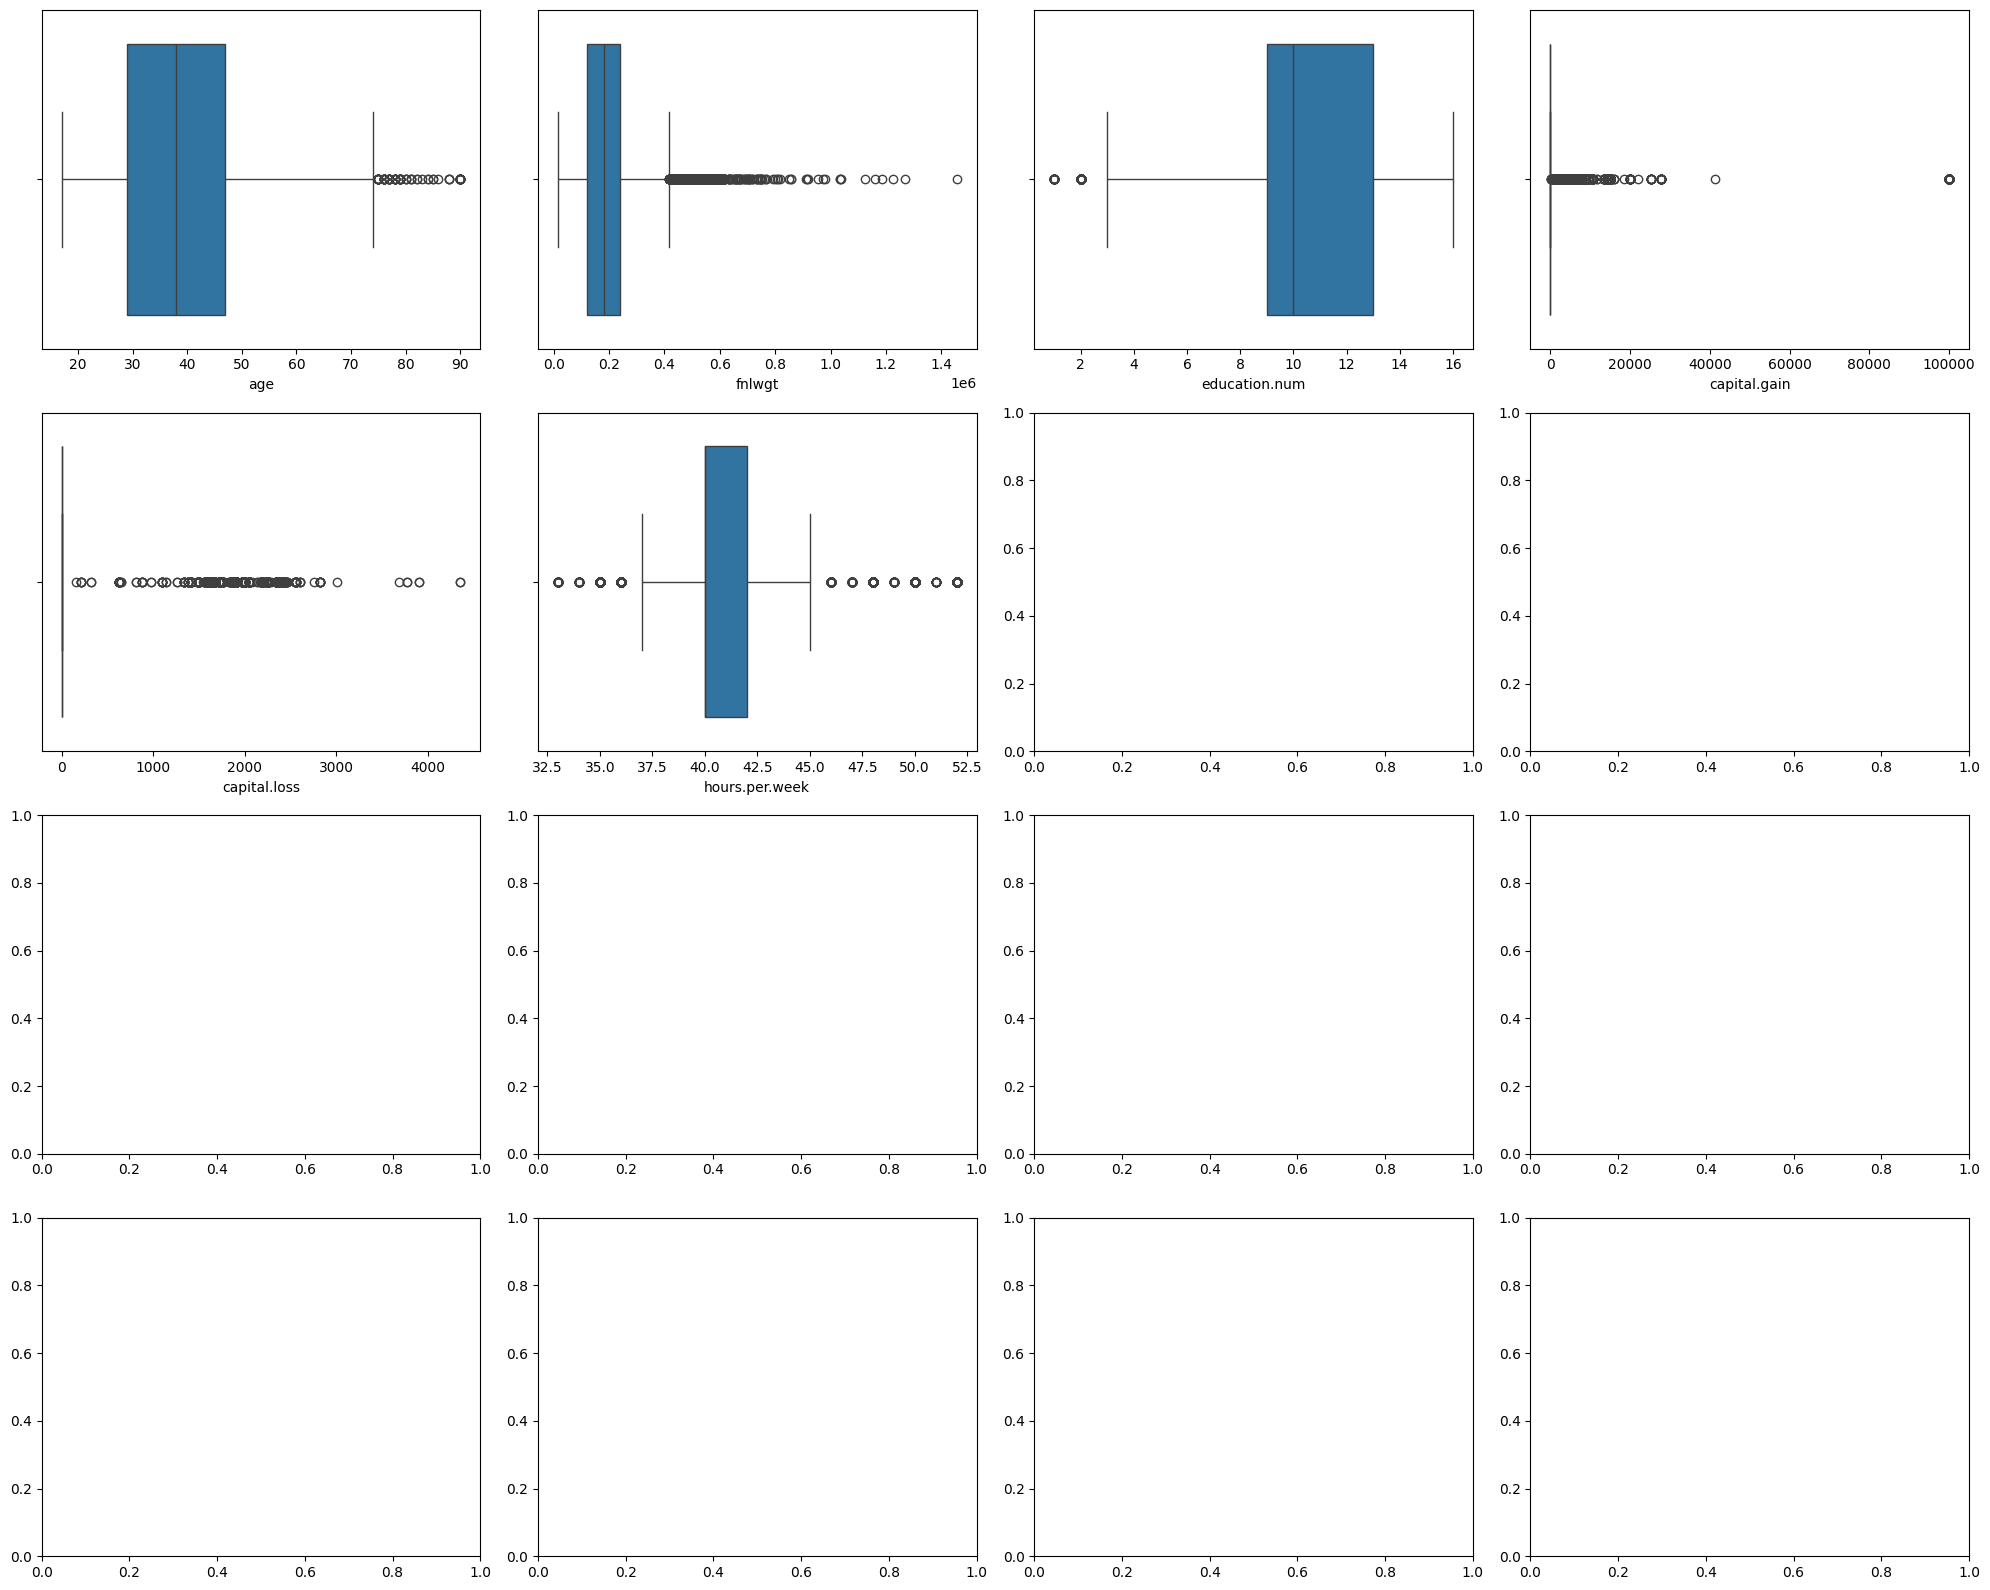

In [7]:
def tratar_outliers(df):
  df_limpo = df.copy()
  for coluna in df.columns:
    if df[coluna].dtype in ['int64','float64']:
      Q1 = df[coluna].quantile(0.25)
      Q3 = df[coluna].quantile(0.75)
      IQR = Q3 - Q1
      lim_inf = Q1 - 1.5 * IQR
      lim_sup = Q3 + 1.5 * IQR

      df_limpo = df[(df[coluna] >= lim_inf) & (df[coluna]<= lim_sup)]
  return df_limpo

adult_sem_outliers = tratar_outliers(adult)
print("Tamanho original:",len(adult))
print("Tamanho sem outliers:",len(adult_sem_outliers))
mostrar_outliers_graficamente(adult_sem_outliers)

In [8]:
##Depois disso, partimos para o pré-processamento do código. A estratégia usada para o pré-processamento foi o OneHotEncoder.

X = adult.drop('income',axis=1)
y = adult['income']

#Separando colunas de categorias e numéricas
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num','passthrough',num_cols),
        ('cat',OneHotEncoder(),cat_cols)
    ]
)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

##Montar a Árvore de Decisão

In [9]:
pipeline_dt = Pipeline(steps=[
    ('preprocessamento',preprocessor),
     ('modelo',DecisionTreeClassifier(random_state=42))
])

pipeline_dt.fit(X_train,y_train)

y_pred_dt = pipeline_dt.predict(X_test)

# Avaliação
print("Árvore de Decisão:\n")
print(classification_report(y_test, y_pred_dt))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_dt))

Árvore de Decisão:

              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      4976
        >50K       0.60      0.62      0.61      1537

    accuracy                           0.81      6513
   macro avg       0.74      0.75      0.74      6513
weighted avg       0.82      0.81      0.81      6513

Matriz de Confusão:
[[4346  630]
 [ 585  952]]


**Análise da árvore de decisão:**

A árvore de decisão apresentou uma boa performance para prever quem ganha <=50k, mas ela tem poblema em prever a classe > 50k. Talvez isso possa ter influência de termos removidos os outliers do dataset.
**Análise da Matriz de Confusão**
Apresentou ainda muitos falsos nefativos para a classe >50k, estando em 585.

##Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

#Pipeline com RandomForest
pipeline_rf = Pipeline(steps=[
    ('preprocessamento',preprocessor),
    ('modelo',RandomForestClassifier(random_state=42))
])

#Treino
pipeline_rf.fit(X_train,y_train)

#predictions
y_pred_rf = pipeline_rf.predict(X_test)

# Avaliação
print("Random Forest:\n")
print(classification_report(y_test, y_pred_rf))

Random Forest:

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4976
        >50K       0.71      0.61      0.65      1537

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513



**Análise da RandomForest**:
A precisão da classe >50k melhora significativamente pelo Random Forest, apesar de o recall ter ficado praticamente o mesmo. O modelo acerta bastante para a classe < 50k.

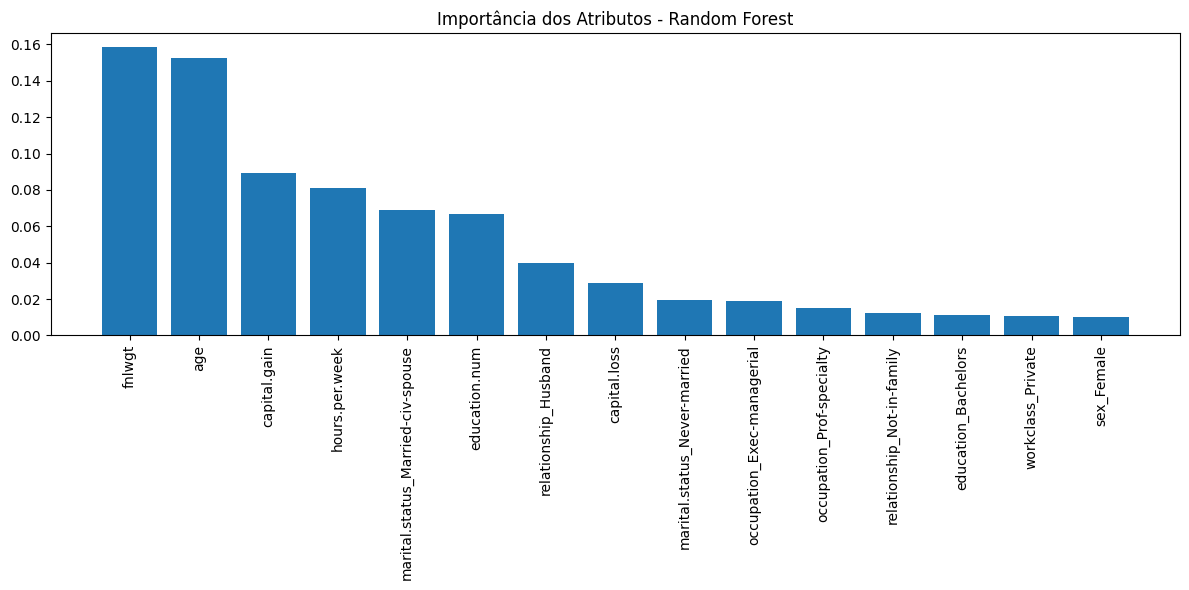

In [11]:
#Gráfico da importancia dos Atributos (para RandomForest)

# Pegar nomes das colunas após o OneHotEncoding
onehot_cols = pipeline_rf.named_steps['preprocessamento'].named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, onehot_cols])

# Importâncias
importances = pipeline_rf.named_steps['modelo'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12,6))
plt.title("Importância dos Atributos - Random Forest")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), feature_names[indices[:15]], rotation=90)
plt.tight_layout()
plt.show()


#Análise da importância dos atributos
fnlwgt -> Apesar de apresentar um valor alto, ele é muitas vezes descartado nas análises.
Age-> Apresenta grande influencia na renda no final. Já que quanto mais velho o indivíduo mais experiencia ele também têm. Então isso de fato faz sentido estar ligado com o aumento na renda.
Capital_gain,hours.per.week, maritial status e education apresenta significante influencia no aumento de ganhos também.
Quanto mais horas trabalhadas maior o ganho do capital, caso o sujeito esteja casado então ele também poderá estar disposto a ganhar mais renda, além disso, a educação também é um fator relevante a ser analisado para o indivíduo.

capital_loss e relationship_husband tem menor impacto, mas ainda assim são relevantes na análise.

Já os demais não apresenta tanta importancia neste modelo de dados que foi analisado.